In [1]:
base_directory = '/home/shoaib/ZTFDataChallenge/'

import sys
sys.path.insert(0, base_directory + 'dmdt_Analysis/')
from dmdt_functions import *

In [2]:
import numpy as np
import pandas as pd
from os import listdir

import warnings
warnings.filterwarnings("ignore")

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=10)

from tqdm.auto import tqdm
tqdm.pandas(desc="Lightcurves Processed")

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 5)

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
plt.rcParams['axes.grid'] = False
# plt.style.use('seaborn-v0_8-colorblind')

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
### Loading the lightcurves by name
lightcurves_by_name = pd.read_pickle(base_directory + 'lightcurves_by_name.pkl').drop(columns=['r_oids', 'g_oids'])
lightcurves_by_name_1day = pd.read_pickle(base_directory + 'lightcurves_by_name_1day_binned.pkl')[['name', 'r_n_good_det', 'r_timespan_good', 'r_lightcurve', 'g_n_good_det', 'g_timespan_good', 'g_lightcurve']]
lightcurves_by_name = lightcurves_by_name.merge(right=lightcurves_by_name_1day, how='inner', on='name', suffixes=(None, '_1day'))
lightcurves_by_name_1day = np.nan
# lightcurves_by_name = lightcurves_by_name.dropna(axis=0)
# lightcurves_by_name = lightcurves_by_name.query("type in @qso_types")
### Sampling to save memory
# lightcurves_by_name = lightcurves_by_name.sample(frac=0.1)

### Loading the lightcurves by OID
lightcurves_by_oid = pd.read_pickle(base_directory + 'lightcurves_by_oid.pkl')
lightcurves_by_oid_1day = pd.read_pickle(base_directory + 'lightcurves_by_oid_1day_binned.pkl')[['oid_alerce', 'n_good_det', 'timespan_good', 'lightcurve']]
lightcurves_by_oid = lightcurves_by_oid.merge(right=lightcurves_by_oid_1day, how='inner', on='oid_alerce', suffixes=(None, '_1day'))
lightcurves_by_oid_1day = np.nan
# lightcurves_by_oid = lightcurves_by_oid.dropna(axis=0)
# lightcurves_by_oid = lightcurves_by_oid.query("type in @qso_types")
### Sampling to save memory
# lightcurves_by_oid = lightcurves_by_oid.sample(frac=0.1)

In [4]:
qso_types = ['Q', 'QR', 'QX']

In [5]:
lightcurves_by_name

,name,type,ra,dec,z,g_timespan_good,g_n_good_det,g_lightcurve,r_timespan_good,r_n_good_det,r_lightcurve,r_n_good_det_1day,r_timespan_good_1day,r_lightcurve_1day,g_n_good_det_1day,g_timespan_good_1day,g_lightcurve_1day
0,1AXG J000605+2031,AX,1.497482,20.523582,0.38,964.688067,229.0,"[[58268.4661921, 17.2914085, 0.0193178076], [5...",981.708229,222.0,"[[58268.4470486, 17.2935829, 0.0198369212], [5...",206.0,962.716157,"[[58268.4470486, 17.2935829, 0.0198369212], [5...",211.0,962.670093,"[[58268.4661921, 17.2914085, 0.0193178076], [5..."
1,1AXG J035008-1149,AX,57.522460,-11.824012,0.45,376.989526,10.0,"[[58390.4113657, 19.8996181, 0.129595727], [58...",340.960799,6.0,"[[58432.3809954, 19.886844600000003, 0.1277610...",4.0,316.086638,"[[58432.3809954, 19.886844600000003, 0.1277610...",5.0,359.060802,"[[58390.4113657, 19.8996181, 0.129595727], [58..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32229,eHAQ0142+0257,QR,25.528603,2.953628,2.31,957.648796,214.0,"[[58298.4827431, 18.9552612, 0.063075698899999...",962.719190,342.0,"[[58301.4430787, 17.906868, 0.0333674327], [58...",184.0,954.707616,"[[58301.4430787, 17.906868, 0.0333674327], [58...",192.0,955.648634,"[[58298.4827431, 18.9552612, 0.063075698899999..."
32230,eHAQ0147+1549,BRX,26.820357,15.828883,0.37,959.672581,416.0,"[[58300.4637847, 19.7455463, 0.107512668], [58...",982.677836,886.0,"[[58288.4649769, 18.7370911, 0.060006402400000...",306.0,978.665405,"[[58288.472511600005, 18.733430887729455, 0.04...",213.0,955.679664,"[[58300.4637847, 19.7455463, 0.107512668], [58..."


In [6]:
lightcurves_by_name['r_dmdt_curve'] = lightcurves_by_name.r_lightcurve.apply(lambda lc: differentiate_lightcurve(lc) if isinstance(lc, np.ndarray) else np.nan)
lightcurves_by_name['g_dmdt_curve'] = lightcurves_by_name.g_lightcurve.apply(lambda lc: differentiate_lightcurve(lc) if isinstance(lc, np.ndarray) else np.nan)

lightcurves_by_name['r_dmdt_curve_1day'] = lightcurves_by_name.r_lightcurve_1day.apply(lambda lc: differentiate_lightcurve(lc) if isinstance(lc, np.ndarray) else np.nan)
lightcurves_by_name['g_dmdt_curve_1day'] = lightcurves_by_name.g_lightcurve_1day.apply(lambda lc: differentiate_lightcurve(lc) if isinstance(lc, np.ndarray) else np.nan)

## We will plot the differenciated curves

### Lightcurves by Name

In [7]:
def plot_single_subfig(subfig, ncols, row):
    object_name = row['name']
    object_type = row['type']

    r_lightcurve, g_lightcurve = row['r_lightcurve'], row['g_lightcurve']
    r_dmdt_curve, g_dmdt_curve = row['r_dmdt_curve'], row['g_dmdt_curve']

    r_lightcurve_1day, g_lightcurve_1day = row['r_lightcurve_1day'], row['g_lightcurve_1day']
    r_dmdt_curve_1day, g_dmdt_curve_1day = row['r_dmdt_curve_1day'], row['g_dmdt_curve_1day']

    subfig.suptitle(f'{object_name} | Type: {object_type}', size=16, y=1.02)
    
    axs = subfig.subplots(nrows=1, ncols=ncols)
    subfig.subplots_adjust(wspace=0.3)
    
    draw_lightcurve(ax=axs[0], band='r', lightcurve=r_lightcurve)
    draw_lightcurve(ax=axs[0], band='g', lightcurve=g_lightcurve)
    axs[0].set_title(f'Original Cadence ({r_lightcurve.shape[0]} $r$, {g_lightcurve.shape[0]} $g$ epochs)')

    draw_dmdt_curve(ax=axs[1], band='r', timeseries=r_dmdt_curve)
    draw_dmdt_curve(ax=axs[1], band='g', timeseries=g_dmdt_curve)
    axs[1].set_title(f'Original Cadence $\\frac{{dM}}{{dt}}$')

    draw_lightcurve(ax=axs[2], band='r', lightcurve=r_lightcurve_1day)
    draw_lightcurve(ax=axs[2], band='g', lightcurve=g_lightcurve_1day)
    axs[2].set_title(f'1-Day Cadence ({r_lightcurve_1day.shape[0]} $r$, {g_lightcurve_1day.shape[0]} $g$ epochs)')

    draw_dmdt_curve(ax=axs[3], band='r', timeseries=r_dmdt_curve_1day)
    draw_dmdt_curve(ax=axs[3], band='g', timeseries=g_dmdt_curve_1day)
    axs[3].set_title(f'1-Day Cadence $\\frac{{dM}}{{dt}}$')

    return axs

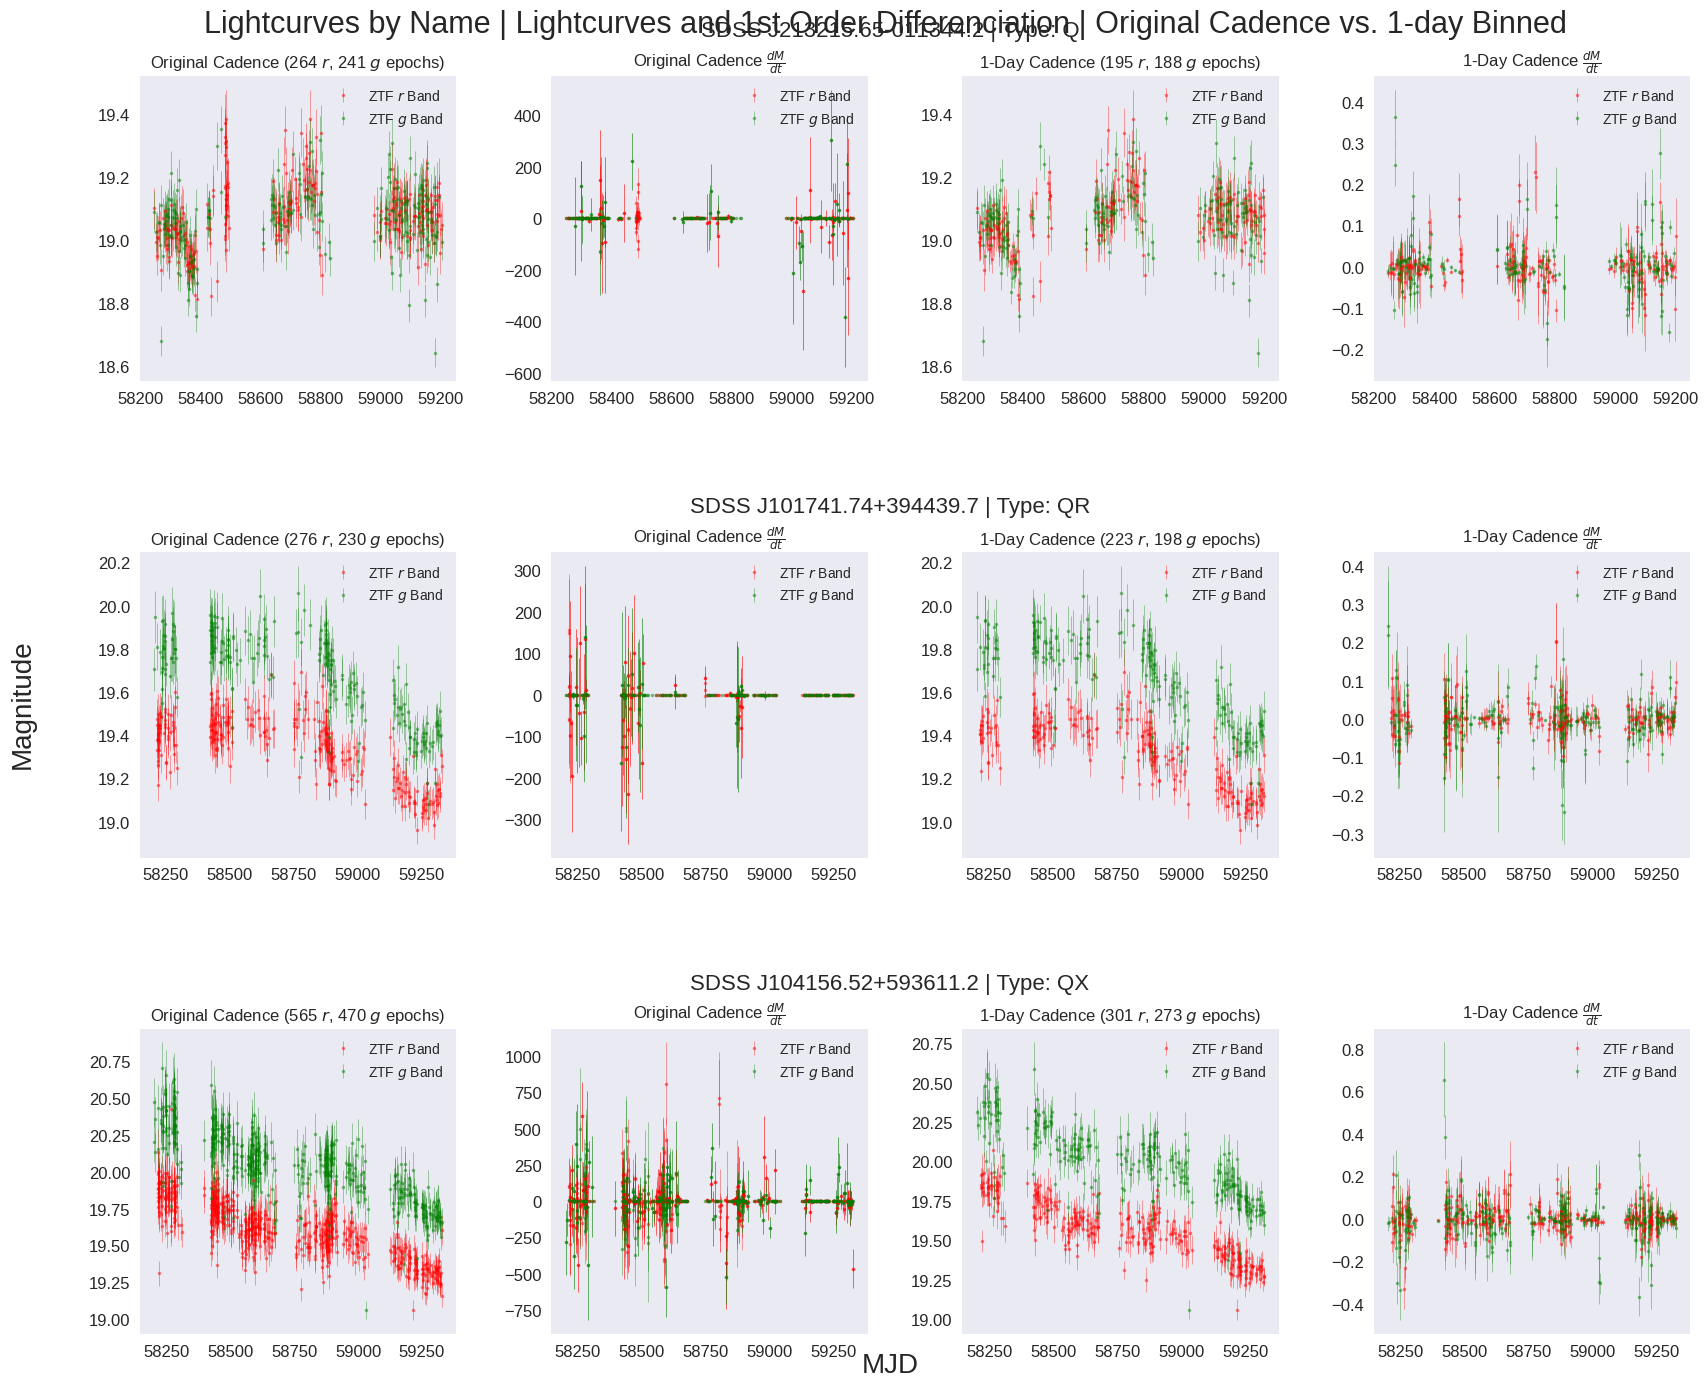

In [8]:
num_examples_per_type = 1
num_examples = num_examples_per_type * 3
sample_df = lightcurves_by_name.dropna(axis=0).query("type in @qso_types")
sample_df = sample_df.groupby('type').sample(num_examples_per_type).reset_index(drop=True)

nrows, ncols = num_examples, 4
fig = plt.figure(figsize=(ncols * 5, nrows * 4.5))
subfigs = fig.subfigures(nrows=nrows, ncols=1, hspace=0.2)

for i, (index, row) in enumerate(sample_df.iterrows()):
    axs = plot_single_subfig(subfigs[i], ncols=ncols, row=row)
    xlabel = axs[0].get_xlabel()
    ylabel = axs[0].get_ylabel()
    for ax in axs:
        ax.legend(fontsize=10)
        ax.set_xlabel('')
        ax.set_ylabel('')

fig.suptitle('Lightcurves by Name | Lightcurves and 1st Order Differenciation | Original Cadence vs. 1-day Binned ', size=22, y=1.014)
fig.supxlabel(xlabel, size=20, y=0)
fig.supylabel(ylabel, size=20, x=0.06)

# plt.tight_layout()
plt.show()

### Lightcurves by OID

In [9]:
lightcurves_by_oid['dmdt_curve'] = lightcurves_by_oid.lightcurve.apply(lambda lc: differentiate_lightcurve(lc) if isinstance(lc, np.ndarray) else np.nan)
lightcurves_by_oid['dmdt_curve_1day'] = lightcurves_by_oid.lightcurve_1day.apply(lambda lc: differentiate_lightcurve(lc) if isinstance(lc, np.ndarray) else np.nan)

In [10]:
def plot_single_subfig(subfig, ncols, row):
    oid = row['oid_alerce']
    band = row['band']
    object_name = row['name']
    object_type = row['type']

    lightcurve, dmdt_curve = row['lightcurve'], row['dmdt_curve']
    lightcurve_1day, dmdt_curve_1day = row['lightcurve_1day'], row['dmdt_curve_1day']

    subfig.suptitle(f'{oid} | {object_name} | Type: {object_type}', size=16, y=1.02)

    axs = subfig.subplots(nrows=1, ncols=ncols)
    subfig.subplots_adjust(wspace=0.3)
    
    draw_lightcurve(axs[0], band, lightcurve)
    axs[0].set_title(f'Original Cadence ({lightcurve.shape[0]} ${band}$ epochs)')

    draw_dmdt_curve(axs[1], band, dmdt_curve)
    axs[1].set_title(f'Original Cadence $\\frac{{dM}}{{dt}}$')

    draw_lightcurve(axs[2], band, lightcurve_1day)
    axs[2].set_title(f'1-Day Cadence ({lightcurve_1day.shape[0]} ${band}$ epochs)')

    draw_dmdt_curve(axs[3], band, dmdt_curve_1day)
    axs[3].set_title(f'1-Day Cadence $\\frac{{dM}}{{dt}}$')

    return axs

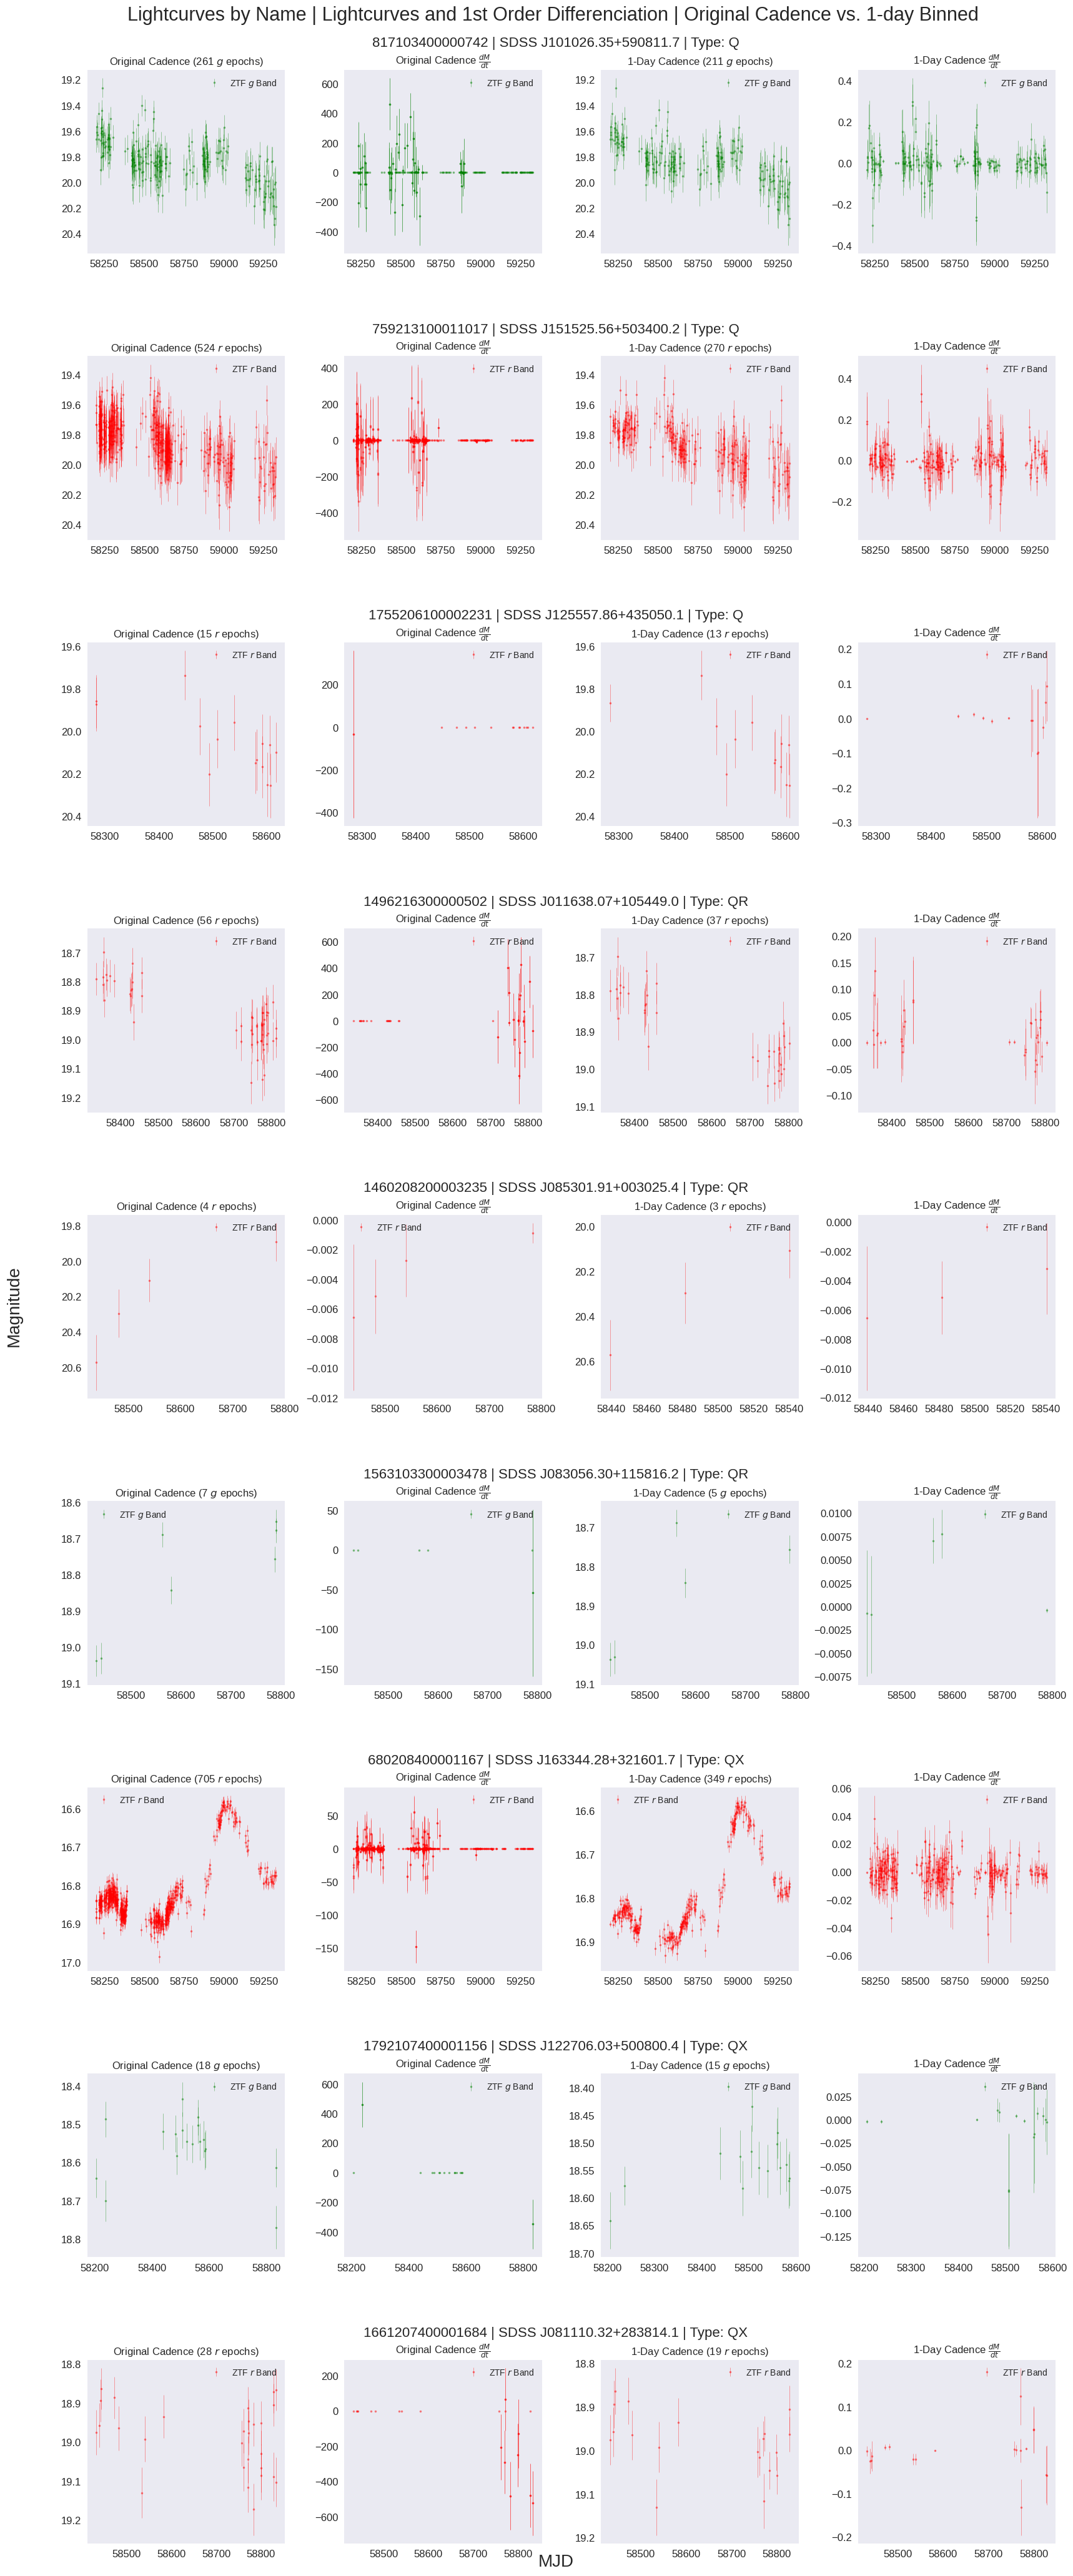

In [11]:
num_examples_per_type = 3
num_examples = num_examples_per_type * 3
sample_df = lightcurves_by_oid.dropna(axis=0).query("type in @qso_types")
sample_df = sample_df.groupby('type').sample(num_examples_per_type).reset_index(drop=True)

nrows, ncols = num_examples, 4
fig = plt.figure(figsize=(ncols * 5, nrows * 4.5))
subfigs = fig.subfigures(nrows=nrows, ncols=1, hspace=0.2)

for i, (index, row) in enumerate(sample_df.iterrows()):
    axs = plot_single_subfig(subfigs[i], ncols=ncols, row=row)
    xlabel = axs[0].get_xlabel()
    ylabel = axs[0].get_ylabel()
    for ax in axs:
        ax.legend(fontsize=10)
        ax.set_xlabel('')
        ax.set_ylabel('')

fig.suptitle('Lightcurves by Name | Lightcurves and 1st Order Differenciation | Original Cadence vs. 1-day Binned ', size=22, y=1.014)
fig.supxlabel(xlabel, size=20, y=0)
fig.supylabel(ylabel, size=20, x=0.06)

# plt.tight_layout()
plt.show()

## Visualising errors in $\frac{dM}{dt}$ curves

In [12]:
def return_combined_timeseries_err_arrays_from_series(series):
    errs_arrays = series.apply(lambda lc: lc[:, 2] if isinstance(lc, np.ndarray) else [np.nan]).to_numpy()
    errs_arrays_combined = np.concatenate(errs_arrays)
    return errs_arrays_combined

def return_combined_timeseries_percent_err_arrays_from_series(series):
    errs_arrays = series.apply(lambda lc: 100 * (lc[:, 2] / lc[:, 1]) if isinstance(lc, np.ndarray) else [np.nan]).to_numpy()
    errs_arrays_combined = np.concatenate(errs_arrays)
    errs_arrays_combined = errs_arrays_combined[~np.isinf(errs_arrays_combined)]
    return errs_arrays_combined

### By Name

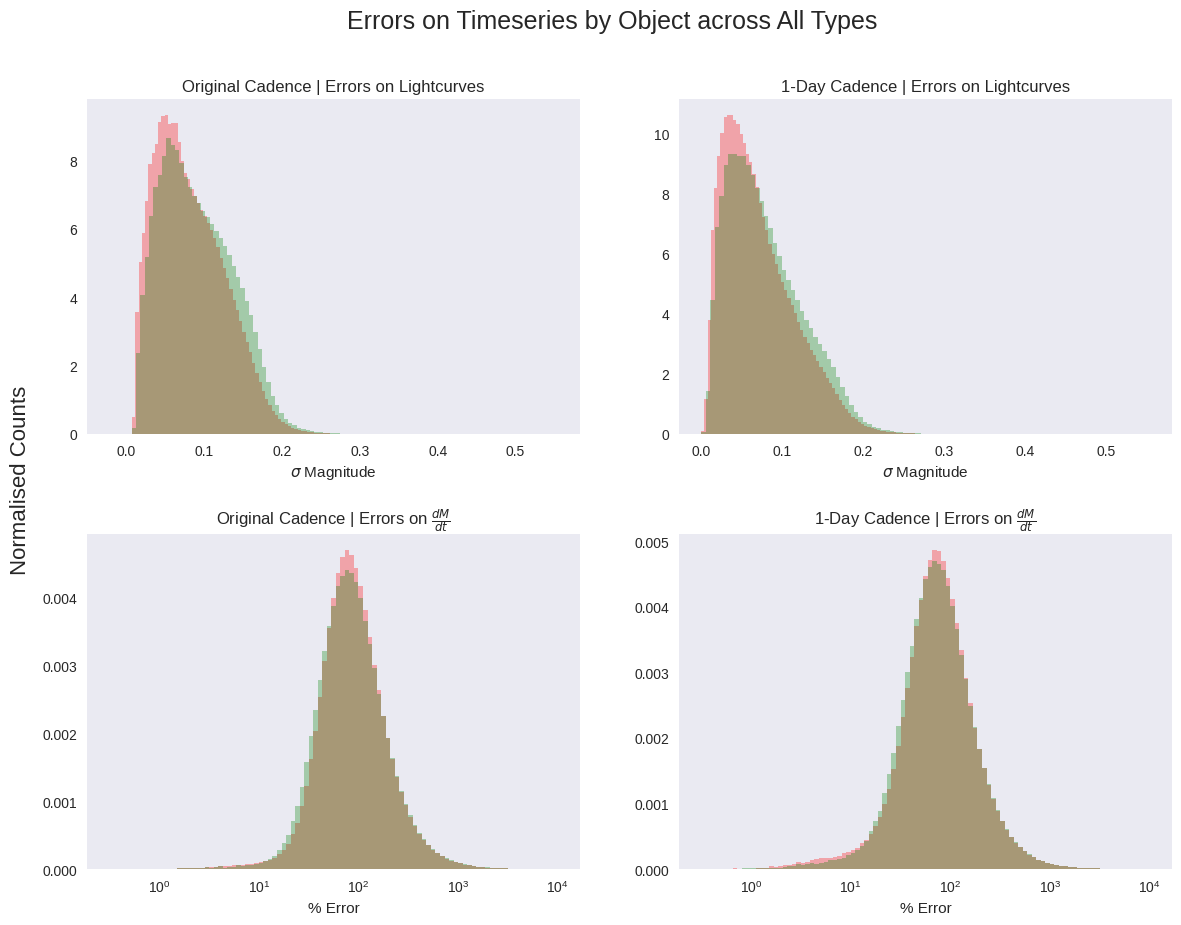

In [13]:
bins = 100
alpha=0.3
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(7*2, 5*2))

r_errs = return_combined_timeseries_err_arrays_from_series(lightcurves_by_name.r_lightcurve)
g_errs = return_combined_timeseries_err_arrays_from_series(lightcurves_by_name.g_lightcurve)
axs[0,0].hist(r_errs, bins=bins, color='r', alpha=alpha, density=True, label='ZTF $r$ Band')
axs[0,0].hist(g_errs, bins=bins, color='g', alpha=alpha, density=True, label='ZTF $g$ Band')
axs[0,0].set_title('Original Cadence | Errors on Lightcurves')
axs[0,0].set_xlabel('$\\sigma$ Magnitude')

r_errs = return_combined_timeseries_err_arrays_from_series(lightcurves_by_name.r_lightcurve_1day)
g_errs = return_combined_timeseries_err_arrays_from_series(lightcurves_by_name.g_lightcurve_1day)
axs[0,1].hist(r_errs, bins=bins, color='r', alpha=alpha, density=True)
axs[0,1].hist(g_errs, bins=bins, color='g', alpha=alpha, density=True)
axs[0,1].set_title('1-Day Cadence | Errors on Lightcurves')
axs[0,1].set_xlabel('$\\sigma$ Magnitude')

bins = np.logspace(-0.5, 4, 100)

r_errs = return_combined_timeseries_percent_err_arrays_from_series(lightcurves_by_name.r_dmdt_curve)
g_errs = return_combined_timeseries_percent_err_arrays_from_series(lightcurves_by_name.g_dmdt_curve)
axs[1,0].hist(r_errs, bins=bins, color='r', alpha=alpha, density=True)
axs[1,0].hist(g_errs, bins=bins, color='g', alpha=alpha, density=True)
axs[1,0].set_title('Original Cadence | Errors on $\\frac{dM}{dt}$')
axs[1,0].set_xlabel('% Error')
axs[1,0].set_xscale('log')

r_errs = return_combined_timeseries_percent_err_arrays_from_series(lightcurves_by_name.r_dmdt_curve_1day)
g_errs = return_combined_timeseries_percent_err_arrays_from_series(lightcurves_by_name.g_dmdt_curve_1day)
axs[1,1].hist(r_errs, bins=bins, color='r', alpha=alpha, density=True)
axs[1,1].hist(g_errs, bins=bins, color='g', alpha=alpha, density=True)
axs[1,1].set_title('1-Day Cadence | Errors on $\\frac{dM}{dt}$')
axs[1,1].set_xlabel('% Error')
axs[1,1].set_xscale('log')

fig.suptitle('Errors on Timeseries by Object across All Types', size=18, y=0.97)
fig.supylabel('Normalised Counts', x=0.07, size=16)

plt.subplots_adjust(hspace=0.3)
plt.show()

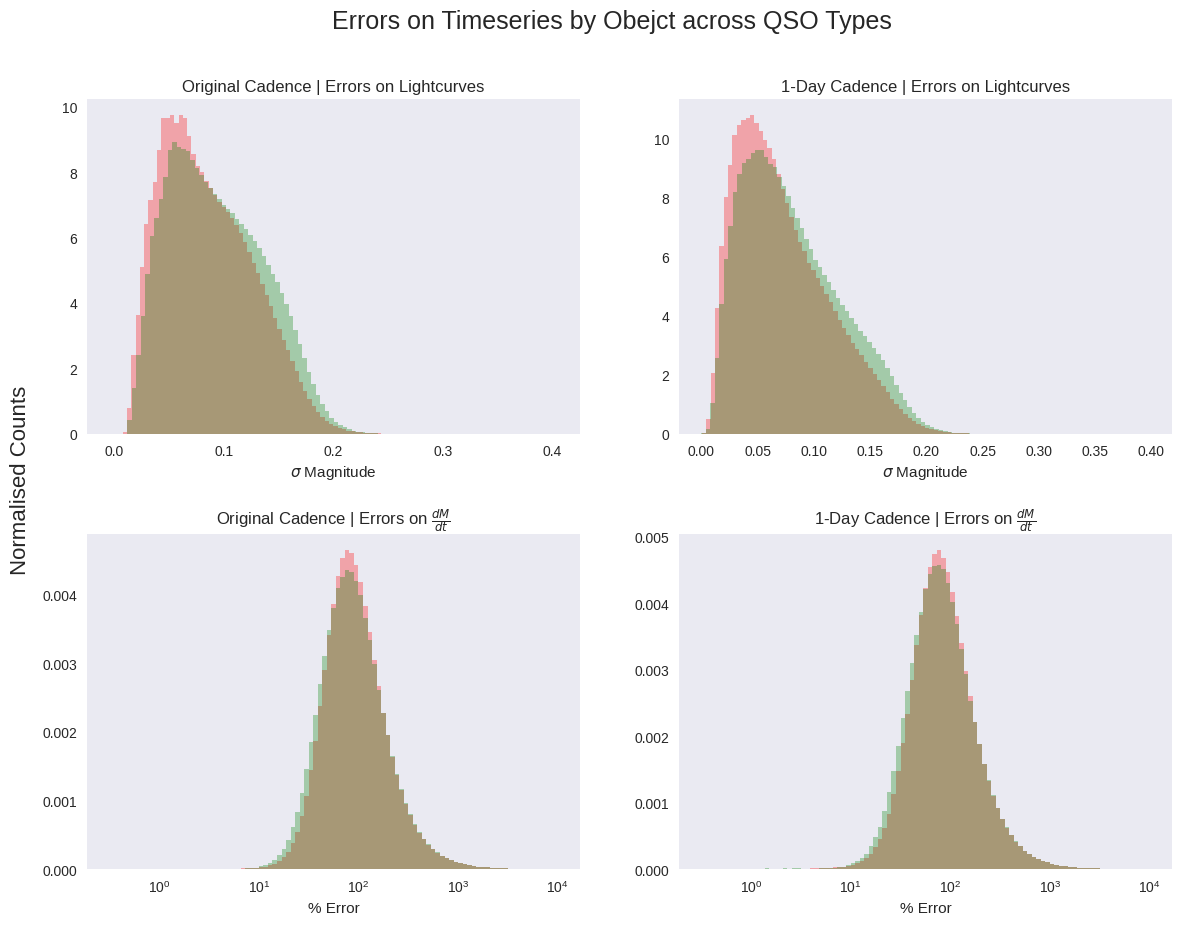

In [14]:
bins = 100
alpha=0.3
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(7*2, 5*2))

r_errs = return_combined_timeseries_err_arrays_from_series(lightcurves_by_name.query("type in @qso_types").r_lightcurve)
g_errs = return_combined_timeseries_err_arrays_from_series(lightcurves_by_name.query("type in @qso_types").g_lightcurve)
axs[0,0].hist(r_errs, bins=bins, color='r', alpha=alpha, density=True, label='ZTF $r$ Band')
axs[0,0].hist(g_errs, bins=bins, color='g', alpha=alpha, density=True, label='ZTF $g$ Band')
axs[0,0].set_title('Original Cadence | Errors on Lightcurves')
axs[0,0].set_xlabel('$\\sigma$ Magnitude')

r_errs = return_combined_timeseries_err_arrays_from_series(lightcurves_by_name.query("type in @qso_types").r_lightcurve_1day)
g_errs = return_combined_timeseries_err_arrays_from_series(lightcurves_by_name.query("type in @qso_types").g_lightcurve_1day)
axs[0,1].hist(r_errs, bins=bins, color='r', alpha=alpha, density=True)
axs[0,1].hist(g_errs, bins=bins, color='g', alpha=alpha, density=True)
axs[0,1].set_title('1-Day Cadence | Errors on Lightcurves')
axs[0,1].set_xlabel('$\\sigma$ Magnitude')

bins = np.logspace(-0.5, 4, 100)

r_errs = return_combined_timeseries_percent_err_arrays_from_series(lightcurves_by_name.query("type in @qso_types").r_dmdt_curve)
g_errs = return_combined_timeseries_percent_err_arrays_from_series(lightcurves_by_name.query("type in @qso_types").g_dmdt_curve)
axs[1,0].hist(r_errs, bins=bins, color='r', alpha=alpha, density=True)
axs[1,0].hist(g_errs, bins=bins, color='g', alpha=alpha, density=True)
axs[1,0].set_title('Original Cadence | Errors on $\\frac{dM}{dt}$')
axs[1,0].set_xlabel('% Error')
axs[1,0].set_xscale('log')

r_errs = return_combined_timeseries_percent_err_arrays_from_series(lightcurves_by_name.query("type in @qso_types").r_dmdt_curve_1day)
g_errs = return_combined_timeseries_percent_err_arrays_from_series(lightcurves_by_name.query("type in @qso_types").g_dmdt_curve_1day)
axs[1,1].hist(r_errs, bins=bins, color='r', alpha=alpha, density=True)
axs[1,1].hist(g_errs, bins=bins, color='g', alpha=alpha, density=True)
axs[1,1].set_title('1-Day Cadence | Errors on $\\frac{dM}{dt}$')
axs[1,1].set_xlabel('% Error')
axs[1,1].set_xscale('log')

fig.suptitle('Errors on Timeseries by Obejct across QSO Types', size=18, y=0.97)
fig.supylabel('Normalised Counts', x=0.07, size=16)

plt.subplots_adjust(hspace=0.3)
plt.show()

### By OID

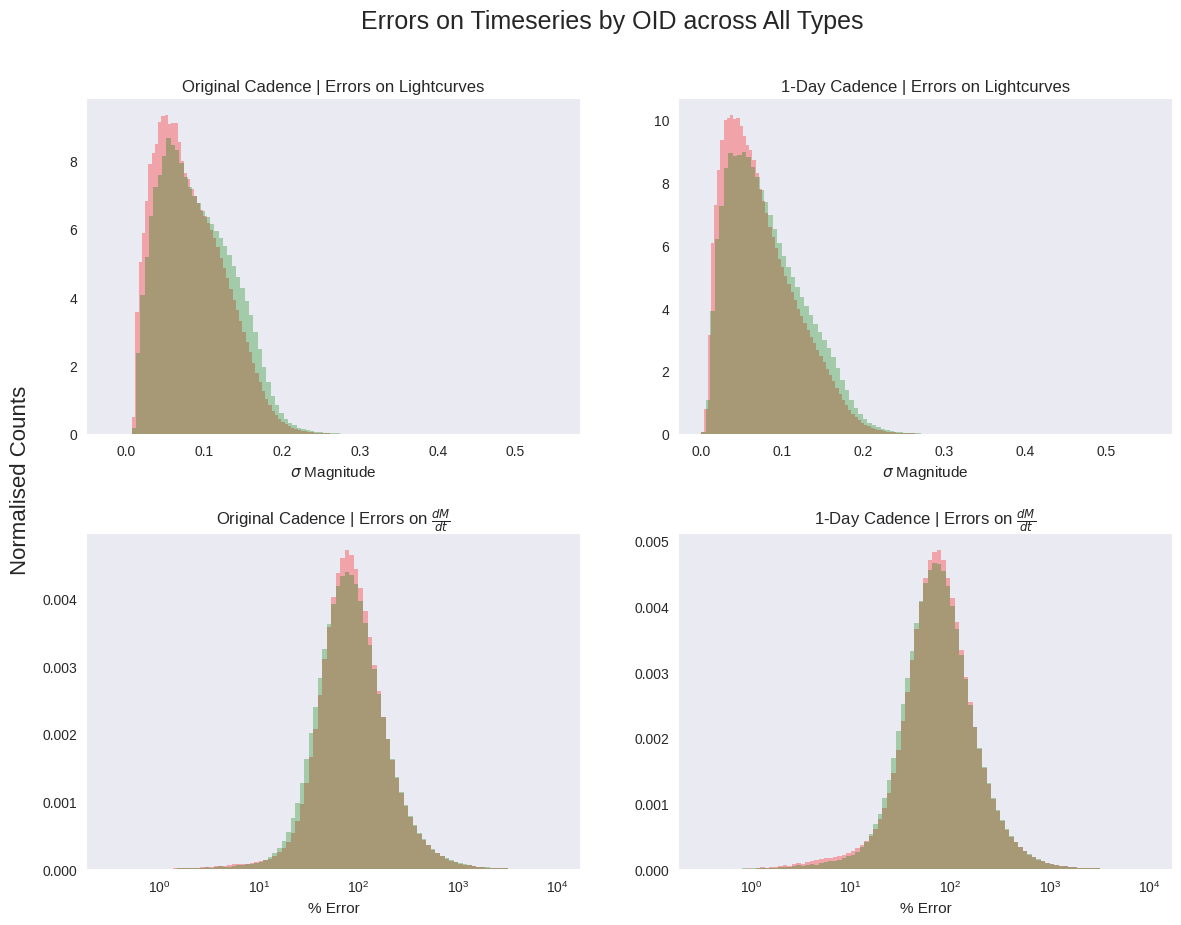

In [15]:
bins = 100
alpha=0.3
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(7*2, 5*2))

r_errs = return_combined_timeseries_err_arrays_from_series(lightcurves_by_oid.query("band == 'r'").lightcurve)
g_errs = return_combined_timeseries_err_arrays_from_series(lightcurves_by_oid.query("band == 'g'").lightcurve)
axs[0,0].hist(r_errs, bins=bins, color='r', alpha=alpha, density=True, label='ZTF $r$ Band')
axs[0,0].hist(g_errs, bins=bins, color='g', alpha=alpha, density=True, label='ZTF $g$ Band')
axs[0,0].set_title('Original Cadence | Errors on Lightcurves')
axs[0,0].set_xlabel('$\\sigma$ Magnitude')

r_errs = return_combined_timeseries_err_arrays_from_series(lightcurves_by_oid.query("band == 'r'").lightcurve_1day)
g_errs = return_combined_timeseries_err_arrays_from_series(lightcurves_by_oid.query("band == 'g'").lightcurve_1day)
axs[0,1].hist(r_errs, bins=bins, color='r', alpha=alpha, density=True)
axs[0,1].hist(g_errs, bins=bins, color='g', alpha=alpha, density=True)
axs[0,1].set_title('1-Day Cadence | Errors on Lightcurves')
axs[0,1].set_xlabel('$\\sigma$ Magnitude')

bins = np.logspace(-0.5, 4, 100)

r_errs = return_combined_timeseries_percent_err_arrays_from_series(lightcurves_by_oid.query("band == 'r'").dmdt_curve)
g_errs = return_combined_timeseries_percent_err_arrays_from_series(lightcurves_by_oid.query("band == 'g'").dmdt_curve)
axs[1,0].hist(r_errs, bins=bins, color='r', alpha=alpha, density=True)
axs[1,0].hist(g_errs, bins=bins, color='g', alpha=alpha, density=True)
axs[1,0].set_title('Original Cadence | Errors on $\\frac{dM}{dt}$')
axs[1,0].set_xlabel('% Error')
axs[1,0].set_xscale('log')

r_errs = return_combined_timeseries_percent_err_arrays_from_series(lightcurves_by_oid.query("band == 'r'").dmdt_curve_1day)
g_errs = return_combined_timeseries_percent_err_arrays_from_series(lightcurves_by_oid.query("band == 'g'").dmdt_curve_1day)
axs[1,1].hist(r_errs, bins=bins, color='r', alpha=alpha, density=True)
axs[1,1].hist(g_errs, bins=bins, color='g', alpha=alpha, density=True)
axs[1,1].set_title('1-Day Cadence | Errors on $\\frac{dM}{dt}$')
axs[1,1].set_xlabel('% Error')
axs[1,1].set_xscale('log')

fig.suptitle('Errors on Timeseries by OID across All Types', size=18, y=0.97)
fig.supylabel('Normalised Counts', x=0.07, size=16)

plt.subplots_adjust(hspace=0.3)
plt.show()

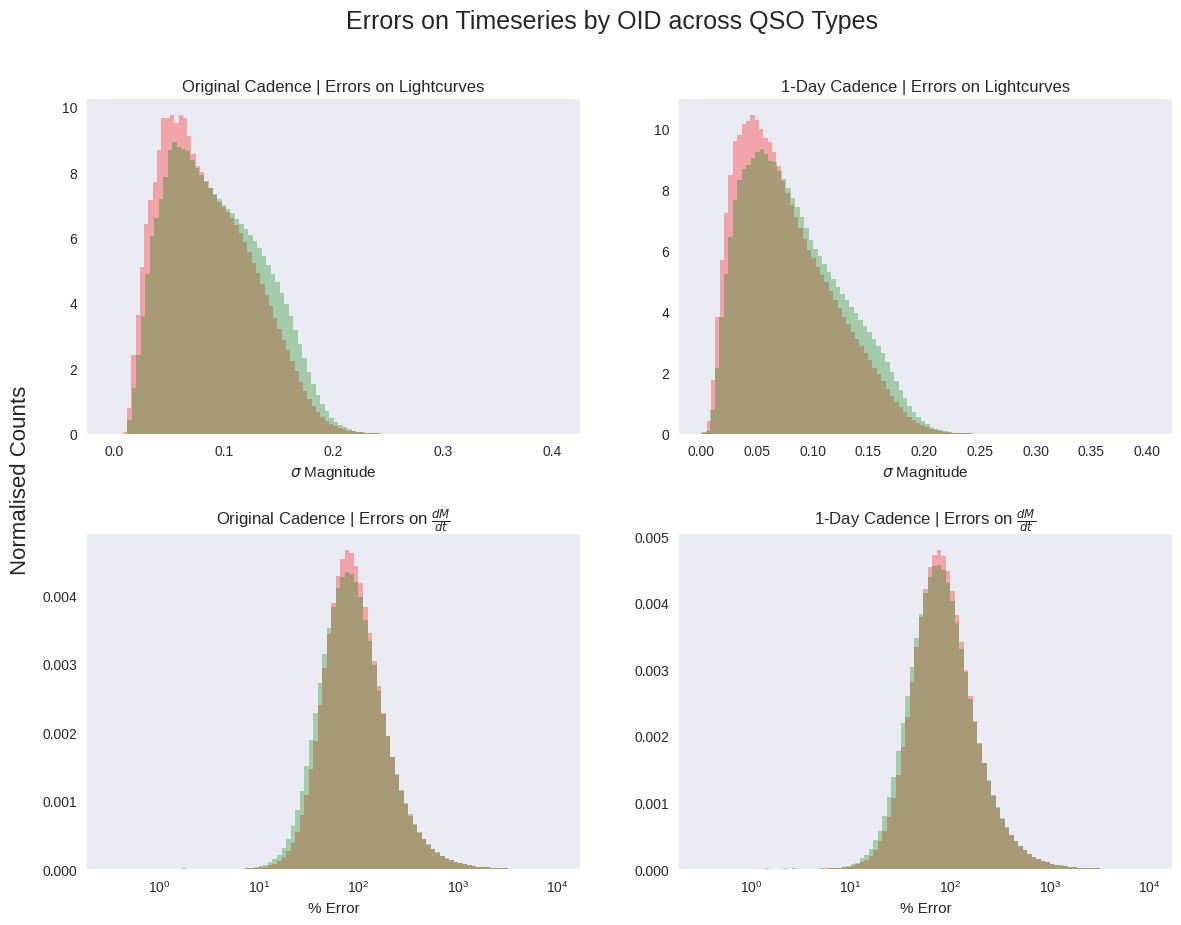

In [16]:
bins = 100
alpha=0.3
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(7*2, 5*2))

r_errs = return_combined_timeseries_err_arrays_from_series(lightcurves_by_oid.query("type in @qso_types and band == 'r'").lightcurve)
g_errs = return_combined_timeseries_err_arrays_from_series(lightcurves_by_oid.query("type in @qso_types and band == 'g'").lightcurve)
axs[0,0].hist(r_errs, bins=bins, color='r', alpha=alpha, density=True, label='ZTF $r$ Band')
axs[0,0].hist(g_errs, bins=bins, color='g', alpha=alpha, density=True, label='ZTF $g$ Band')
axs[0,0].set_title('Original Cadence | Errors on Lightcurves')
axs[0,0].set_xlabel('$\\sigma$ Magnitude')

r_errs = return_combined_timeseries_err_arrays_from_series(lightcurves_by_oid.query("type in @qso_types and band == 'r'").lightcurve_1day)
g_errs = return_combined_timeseries_err_arrays_from_series(lightcurves_by_oid.query("type in @qso_types and band == 'g'").lightcurve_1day)
axs[0,1].hist(r_errs, bins=bins, color='r', alpha=alpha, density=True)
axs[0,1].hist(g_errs, bins=bins, color='g', alpha=alpha, density=True)
axs[0,1].set_title('1-Day Cadence | Errors on Lightcurves')
axs[0,1].set_xlabel('$\\sigma$ Magnitude')

bins = np.logspace(-0.5, 4, 100)

r_errs = return_combined_timeseries_percent_err_arrays_from_series(lightcurves_by_oid.query("type in @qso_types and band == 'r'").dmdt_curve)
g_errs = return_combined_timeseries_percent_err_arrays_from_series(lightcurves_by_oid.query("type in @qso_types and band == 'g'").dmdt_curve)
axs[1,0].hist(r_errs, bins=bins, color='r', alpha=alpha, density=True)
axs[1,0].hist(g_errs, bins=bins, color='g', alpha=alpha, density=True)
axs[1,0].set_title('Original Cadence | Errors on $\\frac{dM}{dt}$')
axs[1,0].set_xlabel('% Error')
axs[1,0].set_xscale('log')

r_errs = return_combined_timeseries_percent_err_arrays_from_series(lightcurves_by_oid.query("type in @qso_types and band == 'r'").dmdt_curve_1day)
g_errs = return_combined_timeseries_percent_err_arrays_from_series(lightcurves_by_oid.query("type in @qso_types and band == 'g'").dmdt_curve_1day)
axs[1,1].hist(r_errs, bins=bins, color='r', alpha=alpha, density=True)
axs[1,1].hist(g_errs, bins=bins, color='g', alpha=alpha, density=True)
axs[1,1].set_title('1-Day Cadence | Errors on $\\frac{dM}{dt}$')
axs[1,1].set_xlabel('% Error')
axs[1,1].set_xscale('log')

fig.suptitle('Errors on Timeseries by OID across QSO Types', size=18, y=0.97)
fig.supylabel('Normalised Counts', x=0.07, size=16)

plt.subplots_adjust(hspace=0.3)
plt.show()

## Let's save these $\frac{dM}{dt}$ curves for now.

In [17]:

lightcurves_by_name[['name', 'r_dmdt_curve', 'g_dmdt_curve', 'r_dmdt_curve_1day', 'g_dmdt_curve_1day']].to_pickle(base_directory + 'd2mdt2_Analysis/dmdt_curves_by_name_direct.pkl')

In [18]:
lightcurves_by_oid[['oid_alerce', 'dmdt_curve', 'dmdt_curve_1day']].to_pickle(base_directory + 'd2mdt2_Analysis/dmdt_curves_by_oid_direct.pkl')